In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb
import sc_eVIP

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='TP53'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 85778 × 1224 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'uninfected', 'vbc.counts', 'batch_num18', 'batch_num8', 'batch_num25', 'batch_num22', 'batch_num24', 'batch_num28', 'batch_num27', 'batch_num23', 'batch_num17', 'batch_num19', 'batch_num12', 'batch_num31', 'batch_num5', 'batch_num15', 'batch_num7', 'batch_num9', 'batch_num4', 'batch_num2', 'batch_num13', 'batch_num6', 'batch_num26', 'batch_num16', 'batch_num10', 'batch_num1', 'batch_num29', 'batch_num0', 'batch_num11', 'batch_num30', 'batch_num3', 'batch_num14', 'batch_num21', 'batch_num20', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'G105C', 'G266E', 'G154V', 'Y220C', 'V216V', 'WT', 'M246V', 'E286K', 'C176Y', 'S366A', 'H193Y', 'L344L', 'E339K', 'P47P', 'V173M', 'V272L', 'R158H', 'C135F', 'A83V', 'L194R', 'T312S', 'S127F', 'R249S', 'R337L', 'R273H', 'V272M', 'R273L', 'Q5R', 'R249M', 

In [4]:
ref='P359P'
#methods=['HotellingT2']

#collect the variants into a list
perturb.pp.get_perturbations(adata,'guide.compact')

variants=adata.uns['PS.guide.compact.list']
variants.append('unassigned')
print(variants)
print(len(variants))

['A159P', 'A159V', 'A83V', 'C135F', 'C135Y', 'C141Y', 'C176F', 'C176Y', 'C238F', 'C238Y', 'C242F', 'C275F', 'C275Y', 'C277F', 'D21D', 'E271K', 'E285K', 'E286K', 'E2E', 'E339K', 'G105C', 'G154V', 'G244C', 'G245C', 'G245D', 'G245S', 'G245V', 'G266E', 'G266R', 'G266V', 'G360V', 'H179R', 'H179Y', 'H193L', 'H193R', 'H193Y', 'H214R', 'I195T', 'K132N', 'K132R', 'L194R', 'L344L', 'M237I', 'M246V', 'P151S', 'P152L', 'P153P', 'P222P', 'P250L', 'P278L', 'P278S', 'P295P', 'P301P', 'P359P', 'P36P', 'P47P', 'P47S', 'P58R', 'Q5R', 'R110L', 'R158H', 'R158L', 'R158R', 'R175H', 'R213Q', 'R248L', 'R248W', 'R249M', 'R249S', 'R273C', 'R273H', 'R273L', 'R280K', 'R280T', 'R282W', 'R337C', 'R337L', 'S127F', 'S241C', 'S241F', 'S366A', 'T118T', 'T170T', 'T312S', 'V157F', 'V173L', 'V173M', 'V216M', 'V216V', 'V272L', 'V272M', 'V31I', 'WT', 'Y107H', 'Y163C', 'Y205C', 'Y220C', 'Y234C', 'Y236C', 'unassigned']
100


In [5]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')

anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
impactful=list(set(list(anno.loc[anno['control_status']=='unknown',:].index)).intersection(set(variants)))
print(len(impactful))

sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
anno['cluster_color']=sorted_variants_df.loc[anno.index,1]
anno.loc['unassigned','cluster_color']='#99CCFF'

['T118T', 'R158R', 'P222P', 'P36P', 'P47P', 'P359P', 'WT', 'E2E', 'P301P', 'T170T', 'V216V', 'P295P', 'P153P', 'D21D', 'L344L']
74


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [9]:
#setup subsampled datasets
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
os.system('mkdir -p '+SUBS_DIR)

subs_list=[1000,900,800,700,600,500,400,300,200,
           190,180,170,160,150,140,130,120,110,
           100,90,80,70,60,50,40,30,20,10]
iters=20
for subs in subs_list:
    print(subs)
    for i in range(iters):
        #out file
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        
        #subsample
        my_rng=np.random.RandomState(i)
        adata_subs=perturb.pp.subsample_cells(adata,subs,'guide.compact',
                                             rng=my_rng)
        
        #write cells
        cells=pd.DataFrame({'cells':adata_subs.obs_names})
        cells.to_csv(out,index=False,header=False)
    print(out)
        

1000


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells1000.cells.csv
900


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells900.cells.csv
800


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells800.cells.csv
700


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells700.cells.csv
600


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells600.cells.csv
500


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells500.cells.csv
400


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells400.cells.csv
300
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells300.cells.csv
200
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells200.cells.csv
190
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells190.cells.csv
180
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells180.cells.csv
170
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/TP53/scoring/subsamples/subsample.iter19.cells170.cells.

In [6]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


0

In [9]:
for i in range(10):
    print('==============',i)
    for subs in [20,10,#50,40,#30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
                
    ]:
        
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()
        
        #HotellingT2 ========================================
        pcs=min(20,subs-1)
        print('pcs',pcs)
        dataset=pd.DataFrame(adata_sub.obsm['X_pca'][:,:pcs],
                     index=adata_sub.obs_names,
                    columns=range(pcs))
        labels=pd.DataFrame({'label':adata_sub.obs['guide.compact']})
        labels.index=adata_sub.obs_names
        
        #compute scores and their FDRs
        scores_hotel=sc_eVIP.score.compare_groups_with_reference(dataset,
                                  labels,
                                 variants,
                                  syn,
                                 methods=['HotellingT2'],
                                 n_bootstrap_controls=0)
        
        #correlation ==========================================
        dataset=pd.DataFrame(adata_sub.X,index=adata_sub.obs_names,
                    columns=adata_sub.var_names)

        scores_corr=sc_eVIP.score.compare_groups_with_reference(dataset,
                                          labels,
                                         variants,
                                          syn,
                                         methods=['avg.pearson'],
                                         n_bootstrap_controls=0) 
        scores_all=scores_corr
        
        for c in scores_hotel.columns:
            if c not in scores_all.columns:
                scores_all[c]=scores_hotel.loc[scores_all.index,c]

        out=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_all.to_csv(out)

============== 0
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 1
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 2
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 3
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 4
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 5
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 controls
99 %Found 15/15 controls
99 %============== 6
cells 20
pcs 19
Found 15/15 controls
99 %Found 15/15 controls
99 %cells 10
pcs 9
Found 15/15 co

In [16]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter1.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]
scores.head()

,avg.pearson.mean,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.high,avg.pearson.q,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,HotellingT2.q
unassigned,0.714310,0.693012,0.735607,0.000010,166.613475,154.356764,178.870186,0.000010
V173M,1.527210,1.511067,1.543353,0.000010,373.069918,347.948069,398.191767,0.000010
P47S,0.288396,0.274315,0.302478,0.444444,35.886533,31.691899,40.081167,0.320944
P152L,0.947292,0.928515,0.966069,0.000010,117.255268,107.122465,127.388071,0.000010
C176Y,1.422377,1.407831,1.436922,0.000010,246.055616,229.470321,262.640912,0.000010


thresh 71.34803692751143


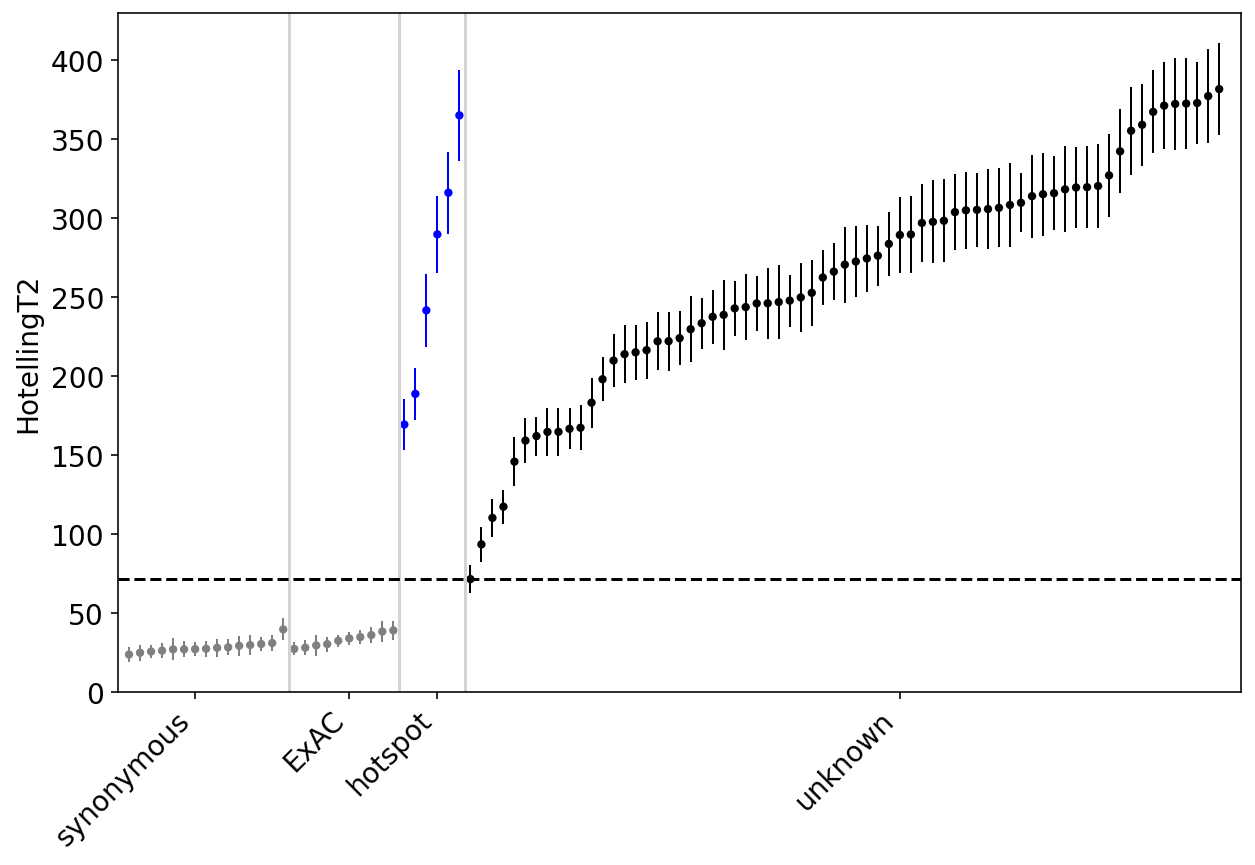

thresh 0.4224393316553798


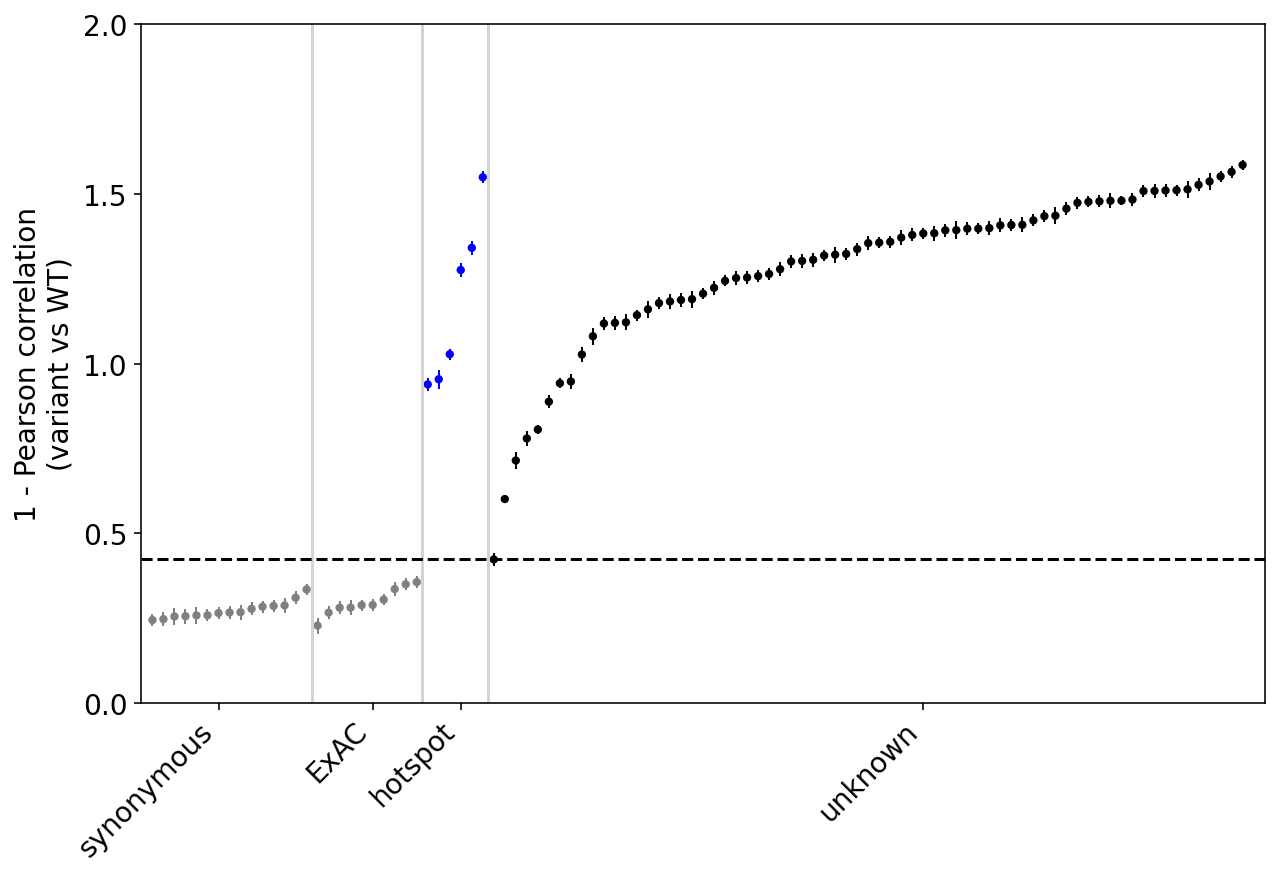

In [17]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,scorename,signame,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[signame]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=scorename,ascending=False)
    score_thresh_value=float(list(fdr_passed[scorename])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.mean']=scores.loc[anno.index,method+'.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.sort_values(by=['control_status2',method+'.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.mean'],
                        #scores.loc[anno.index,method],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[:,'text_color']),

                        s=10,
                       c=list(anno.loc[:,'text_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=30.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,1.5)
        plots.set_yticks([0,0.5,1.0,1.5,2.0])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,28,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,scorename=method+'.mean',
                                signame=method+'.q',
                                FDR=0.01)
    print('thresh',thresh)
    plt.axhline(y=thresh,color='black',linestyle='--')
    plt.show()

In [11]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [12]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'
for i in range(10):
    print(i)
    outs[i]={}
    for subs in [50,40,#30,20,10,
        1000,900,800,700,600,500,400,300,200,
                 190,180,170,160,150,140,130,120,110,
                 100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)
        print(scores_real2.head())

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                print(method,fdr,'impactful',len(impactful))
                
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                
                #now, go through each cluster of variants and compute (vs original ctrls)
                for cl in ['#99CCFF', 'navy']:
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    res[method]=pd.concat([res[method],res_here])
                
                
                
    

0
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.874069                 0.836161   
V173M               1.093889                 1.070310   
P47S                0.830214                 0.783761   
P152L               1.001245                 0.990808   
C176Y               1.041071                 1.019195   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.911978       0.559494         28.582167   
V173M                       1.117467       0.000010         49.654747   
P47S                        0.876667       0.671976         25.395413   
P152L                       1.011681       0.073118         29.230318   
C176Y                       1.062948       0.050370         38.187405   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                23.467034                 33.697300       0.685999  
V173M                     37.289752                 62.019

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:77: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.903050                 0.882559   
V173M               1.312079                 1.284249   
P47S                0.487197                 0.463018   
P152L               0.986816                 0.972270   
C176Y               1.143574                 1.125637   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.923542       0.000010         69.039204   
V173M                       1.339908       0.000010        134.812088   
P47S                        0.511376       0.662245         21.527318   
P152L                       1.001362       0.000010         62.353157   
C176Y                       1.161511       0.000010         98.725859   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                62.544291                 75.534116       0.000010  
V173M                    126.070207                143.55396

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.941027                 0.913231   
V173M               1.124236                 1.082888   
P47S                0.855399                 0.826124   
P152L               0.998623                 0.981197   
C176Y               1.000566                 0.978630   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.968824       0.503937         27.785177   
V173M                       1.165583       0.000010         58.310227   
P47S                        0.884673       0.680635         20.697329   
P152L                       1.016048       0.335238         38.430711   
C176Y                       1.022501       0.335238         24.902082   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                23.905191                 31.665163       0.542652 

true 14
true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.912117                 0.894099   
V173M               1.193870                 1.151028   
P47S                0.649427                 0.611963   
P152L               0.962751                 0.946170   
C176Y               1.038386                 1.018716   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.930134       0.000010         44.674499   
V173M                       1.236712       0.000010         72.580603   
P47S                        0.686890       0.702671         18.379999   
P152L                       0.979333       0.000010         51.153566   
C176Y                       1.058055       0.000010         58.099567   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                39.775592                 49.573407       0

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
3
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.922685                 0.896665   
V173M               0.993080                 0.966930   
P47S                0.940176                 0.915585   
P152L               0.922113                 0.895226   
C176Y               1.040402                 1.025262   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.948706       0.084982         31.090718   
V173M                       1.019229       0.000010         44.459838   
P47S                        0.964768       0.000010         24.455826   
P152L                       0.948999       0.084982         34.952561   
C176Y                       1.055543       0.000010         36.743275   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                26.573421                 35.608015       0.52702

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.813176                 0.773750   
V173M               1.248818                 1.230232   
P47S                0.585222                 0.560351   
P152L               1.069008                 1.036500   
C176Y               1.148531                 1.130020   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.852602       0.000010         53.528337   
V173M                       1.267404       0.000010        109.086958   
P47S                        0.610093       0.655462         24.008538   
P152L                       1.101516       0.000010         59.808765   
C176Y                       1.167043       0.000010         84.549691   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                45.493024                 61.563650       0.000010 

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.715595                 0.698230   
V173M               1.514640                 1.498191   
P47S                0.295726                 0.281864   
P152L               0.947222                 0.929141   
C176Y               1.418247                 1.404382   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.732959       0.000010        137.085764   
V173M                       1.531089       0.000010        338.531868   
P47S                        0.309588       0.547215         35.331548   
P152L                       0.965302       0.000010        114.456065   
C176Y                       1.432112       0.000010        239.078467   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned               125.394908                148.776620       0.000010 

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.785290                 0.753890   
V173M               1.129360                 1.107328   
P47S                0.692949                 0.667976   
P152L               1.010975                 0.986510   
C176Y               1.066126                 1.044055   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.816690       0.109640         39.027088   
V173M                       1.151392       0.000010         75.493997   
P47S                        0.717922       0.568675         21.188774   
P152L                       1.035439       0.000010         46.286264   
C176Y                       1.088198       0.000010         72.616939   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                33.708692                 44.345483       0.056895 

true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.924480                 0.898585   
V173M               1.186641                 1.151344   
P47S                0.804237                 0.776320   
P152L               0.936279                 0.899285   
C176Y               1.112951                 1.070981   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.950375       0.177778         26.666900   
V173M                       1.221939       0.000010         67.589726   
P47S                        0.832153       0.590782         22.685071   
P152L                       0.973274       0.110476         33.057869   
C176Y                       1.154922       0.000010         47.583865   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                22.614952                 30.718847       0.568919 

true 14
true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.839569                 0.809896   
V173M               1.281237                 1.260775   
P47S                0.657015                 0.631431   
P152L               1.031414                 1.003617   
C176Y               1.258189                 1.231169   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.869242       0.000010         49.889984   
V173M                       1.301699       0.000010        130.764581   
P47S                        0.682600       0.477551         23.950534   
P152L                       1.059211       0.000010         50.404415   
C176Y                       1.285208       0.000010         86.244260   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                44.027442                 55.752527       0

true 14
true 60
avg.pearson 0.05 impactful 75
true 75
true 14
true 60
            avg.pearson.mean  avg.pearson.ci.0.95.low  \
unassigned          0.926264                 0.904125   
V173M               1.100582                 1.079140   
P47S                0.686983                 0.661767   
P152L               0.875056                 0.857481   
C176Y               1.147682                 1.125604   

            avg.pearson.ci.0.95.high  avg.pearson.q  HotellingT2.mean  \
unassigned                  0.948403       0.000010         44.670622   
V173M                       1.122024       0.000010         88.841252   
P47S                        0.712198       0.605714         19.657710   
P152L                       0.892632       0.000010         27.791632   
C176Y                       1.169760       0.000010         59.181683   

            HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  HotellingT2.q  
unassigned                38.543422                 50.797822       0

In [13]:
res[method]

,FDR,FP,cells,cluster,recall
50.0.05.0,0.05,0.000000,50,all,0.306667
50.0.05.0.cl#99CCFF,0.05,1.000000,50,#99CCFF,0.000000
50.0.05.0.clnavy,0.05,0.000000,50,navy,0.383333
40.0.05.0,0.05,0.000000,40,all,0.360000
40.0.05.0.cl#99CCFF,0.05,1.000000,40,#99CCFF,0.000000
40.0.05.0.clnavy,0.05,0.000000,40,navy,0.450000
1000.0.05.0,0.05,0.000000,1000,all,1.000000
1000.0.05.0.cl#99CCFF,0.05,0.000000,1000,#99CCFF,1.000000
1000.0.05.0.clnavy,0.05,0.000000,1000,navy,1.000000
900.0.05.0,0.05,0.000000,900,all,1.000000


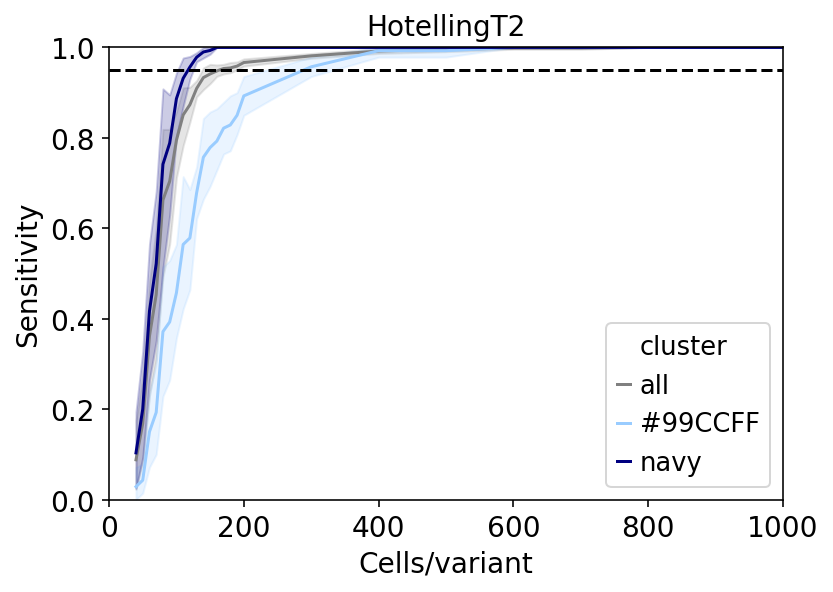

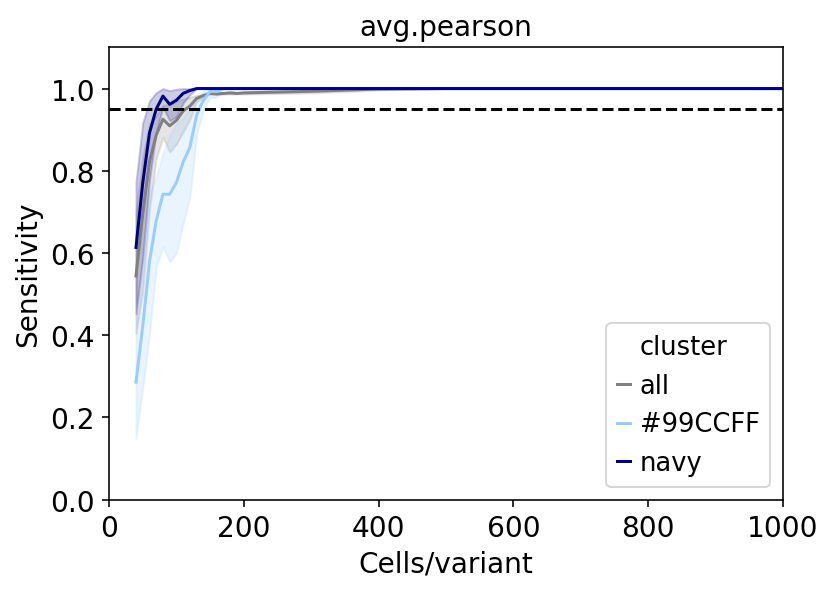

In [14]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

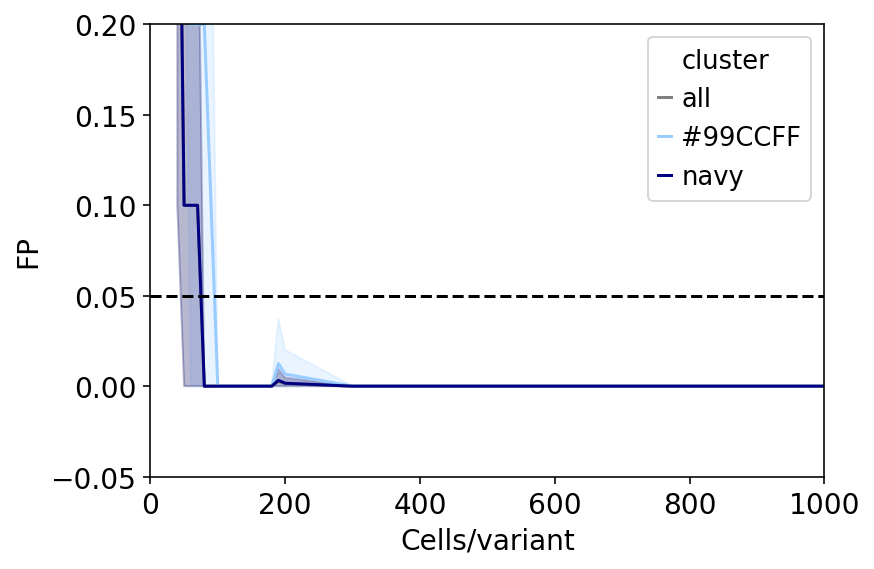

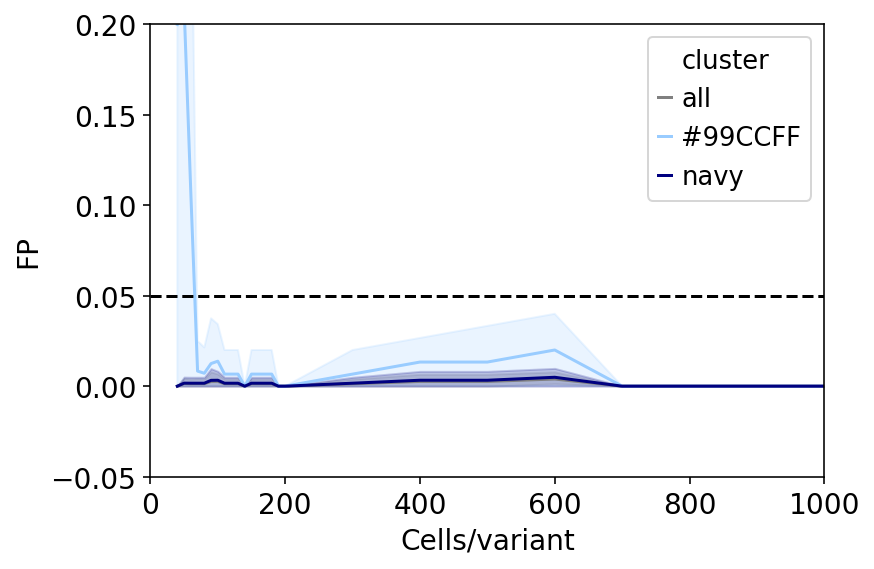

In [15]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [113]:
def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)

def compare_two_groups(adata_here,
                       grouping_variable,
                       g1,g2,
                       methods=['HotellingT2','avg.pearson','avg.spearman','avg.L1'],
                       num_pcs_hotelling=20):
    
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    g1_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g1]
    g2_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g2]
    
    comparison_name=g1+'.VS.'+g2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,g1_cells,g2_cells,method)
        else:
            v=compare_2_groups_df(data_here,g1_cells,g2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=g1
        df_comparison.loc[comparison_name,'group2']=g2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)

def get_conf_interval(data,ci_size=0.95):
    from scipy.stats import t, sem

    #create 95% confidence interval for population mean weight
    ci1,ci2=t.interval(alpha=ci_size, df=len(data)-1, 
               loc=np.mean(data), scale=sem(data)) 
    return(ci1,ci2)

#convert our scores to empirical p-values
def empirical_pvalues(values_df,empirical_dist):
    
    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5):
    plt.hist(ps,30)
    plt.show()
    thresh=0.5
    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    to_return={}
    
    for method in methods:
        res_combo=pd.concat([res_true.loc[:,['dataset','group2',method]],
                             res_perm.loc[:,['dataset','group2',method]]],axis=0)
        min_fdr=1.0/res_combo.shape[0]
        print('min fdr',min_fdr,res_combo.shape)
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr)) 
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
        to_return[method]=res_combo.loc[res_combo['dataset']=='true data',:]
        to_return[method]=to_return[method].drop(columns=['dataset'])
        to_return[method].index=list(to_return[method]['group2'])
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()
            
    return(to_return)


def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=20):
    
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
    
    import copy
    followup=copy.deepcopy(groups)
    for c in controls_for_ci_found:
        followup.append(c)
    followup=list(set(followup))
    counter=0
    for group in followup:
        counter+=1
        perturb.util.display_progress(counter,len(followup))
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        if len(controls_for_ci_found)>0:
            control_scores={}
            #get scores for each control, so we can compute a confidence interval
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = emp_scores[~np.isnan(emp_scores)]
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method],emp_scores)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [ ]:
#### works




def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['avg.pearson'],
                                 num_pcs_hotelling=20):
    
    #checks 
    import copy
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
  
  
    #for storing results
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    #total list of groups to test = groups + ones for CI
    totest=list(set(groups).union(set(controls_for_ci_found)))
    
    #go through each test
    counter=0
    for group in totest:
        counter+=1
        perturb.util.display_progress(counter,len(totest))
        
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        
        #test group vs reference
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        #compute CI for this group
        if len(controls_for_ci_found)>0:
            control_scores={}
            #score against each control
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
                    
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
    
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method+'.ci.'+str(ci_size)+'.mean'],emp_scores)
        print('computed ps===',emp_p)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [216]:
def empirical_pvalues(values_df,empirical_dist):

    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5,thresh=0.5):

    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)


def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)


def df_to_CI(res_df,score_cols,controls,control_col='group2',test_col='group1',ci_size=0.95):
    
    res_df.index=range(res_df.shape[0])
    groups=list(set(res_df[test_col]))
    res_cols=[]
    for score_col in score_cols:
        res_cols.append(score_col+'.mean')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.low')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.high')
        
    res_ci=pd.DataFrame(index=groups,columns=res_cols)
    for score_col in score_cols:
        for group in groups:
            rows=list(set(list(res_df.loc[res_df[test_col]==group,:].index)).intersection(set(list(res_df.loc[res_df[control_col].isin(controls),:].index))))
            group_scores=res_df.loc[rows,score_col]
            conf_intervals=get_conf_interval(group_scores,ci_size=ci_size)
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
            res_ci.loc[group,score_col+'.mean']=np.mean(group_scores)
    return(res_ci)

def get_empirical_q(res_full,res_ci,
                    controls,
                    score_cols,
                    control_col='group2',test_col='group1'):

    for score_col in score_cols:
        
        rows1=list(res_full.loc[res_full[control_col].isin(controls),:].index)
        rows2=list(res_full.loc[res_full[test_col].isin(controls),:].index)
        rows=list(set(rows1).intersection(set(rows2)))
        
        emp_scores=np.array(res_full.loc[rows,score_col].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        
        #q-values
        emp_p=empirical_pvalues(res_ci[score_col+'.mean'],emp_scores)
        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        res_ci[score_col+'.q']=qvalue(np.array(emp_p_combo))[:res_ci.shape[0]]
    return(res_ci)

def display_progress(cur_num,max_num):
    sys.stdout.write('\r'+str(int(100*(1.0*cur_num/max_num)))+' %')
    sys.stdout.flush()

def compare_groups_with_reference(data_df,
                                  labels_df,
                                 groups,
                                  controls,
                                 methods=['HotellingT2','avg.pearson'],
                                 n_bootstrap_controls=0,
                                 rng=np.random.RandomState(1234)):
    
    import copy
    groups_found=list(set(labels_df['label']))
    controls_found=list(set(groups_found).intersection(set(controls)))
    if len(controls_found)>0:
        print('Found '+str(len(controls_found))+'/'+str(len(controls_found))+' controls')
    else:
        print('ERROR: No controls found.')
        return()
    
    #setup result data
    res_col=['group1','group2']
    for c in methods:
        res_col.append(c)
    res=pd.DataFrame(columns=res_col)
    
    #score groups against all controls, and all controls against all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_found,columns=groups_found)
        
    #get group cells 
    group_cells_d={}
    for group in groups:
        if group not in groups_found:
            print('WARNING: group "'+group+'" is not in label data frame. Skipping')
            return
        group_cells=list(labels_df.loc[labels_df['label']==group].index)
        group_cells_d[group]=group_cells
        
    #get control cells
    control_cells_d={}
    controls_found_plus_bootstraps=[]
    for control in controls_found:
        controls_found_plus_bootstraps.append(control)
        control_cells=list(labels_df.loc[labels_df['label']==control].index)
        control_cells_d[control]=control_cells
        #if bootstrapping, sample with replacement from the control cells
        for b in range(n_bootstrap_controls):
            control_cells_d[control+'boot'+str(b)]=rng.choice(control_cells,size=len(control_cells))
            controls_found_plus_bootstraps.append(control+'boot'+str(b))
        
    #score groups against all controls
    counter=0
    for group in groups:
        group_cells=group_cells_d[group]
        counter+=1
        display_progress(counter,len(groups_found))
        
        for control in controls_found_plus_bootstraps:
            if control==group:
                continue
            #group is a test group and control is a bootstrapped one, skip test
            if group not in controls_found and control not in controls_found:
                continue
            control_cells=control_cells_d[control]
            res_here=pd.DataFrame({'group1':[group],
                                  'group2':[control]},index=[group+'.'+control])
            
            for method in methods:
                method_score=compare_2_groups_df(data_df.loc[list(set(group_cells).union(set(control_cells))),:],
                     group_cells,control_cells,
                     method)
                
                res_here[method]=method_score    
        
            res=pd.concat([res,res_here],axis=0,sort=True)
    res.index=list(res['group2'])
    
    #make confidence intervals
    res_ci=df_to_CI(res,methods,
                    controls_found_plus_bootstraps,
                    control_col='group2',
                    test_col='group1',
                    ci_size=0.95)
    
    #get qvalues from empirical p-values
    res_ci=get_empirical_q(res,res_ci,
                    controls=controls_found_plus_bootstraps,
                    control_col='group2',test_col='group1',
                    score_cols=methods)
    
    return(res_ci)
        
 

Found 15/15 controls
100 %

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['avg.pearson'],
                                 n_bootstrap_controls=1)       

In [210]:
dataset=pd.DataFrame(adata.obsm['X_pca'][:,:20],
                     index=adata.obs_names,
                    columns=range(20))
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [219]:
res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['HotellingT2'],
                                 n_bootstrap_controls=1) 

Found 15/15 controls
100 %

In [220]:
x=res_out

In [221]:
x.loc[syn,:]

,HotellingT2.mean,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.high,HotellingT2.q
P222P,33.0589,28.2094,37.9083,0.698462
T170T,27.9802,23.7892,32.1712,0.751331
D21D,30.0617,24.7117,35.4116,0.741814
P153P,31.4951,27.8491,35.1411,0.728806
P36P,31.0464,26.6651,35.4278,0.730230
L344L,34.2922,29.6069,38.9775,0.684379
WT,30.1281,26.2394,34.0168,0.741814
E2E,32.0898,27.9633,36.2162,0.717991
R158R,29.3599,25.3814,33.3383,0.741561
P301P,29.3597,25.624,33.0955,0.741561


In [128]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


res={}
outs={}
methods=['HotellingT2','avg.pearson','avg.L1']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP'])
    

    


cells 1000
Found 15/15 controls for CI computation
100 %

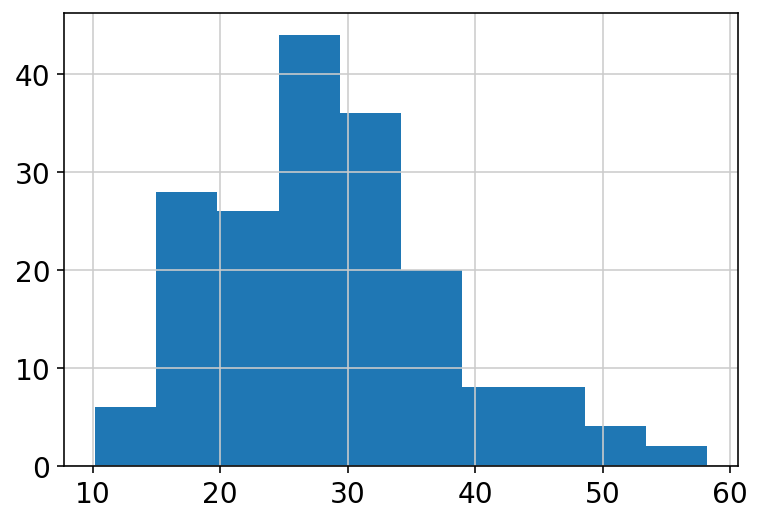

computed ps=== [0.         0.         0.         0.         0.52747253 0.
 0.54945055 0.         0.42857143 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.3956044  0.         0.         0.         0.         0.
 0.53846154 0.         0.51648352 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.46153846 0.46153846 0.24175824 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.67032967 0.58241758 0.62637363 0.
 0.42857143 0.         0.         0.         0.31868132 0.
 0.         0.69230769 0.         0.3956044  0.12087912 0.
 0.         0.         0.12087912 0.         0.         0.41758242
 0.         0.17582418 0.         0.         0.         0.
 0.         0.         0.         0.54945055 0.         0.
 0.         0.         0.37362637 0.         0.46153846 0.
 0.         0.         0.         0.         0.         0.
 0.23076923 0.0989011  0.        

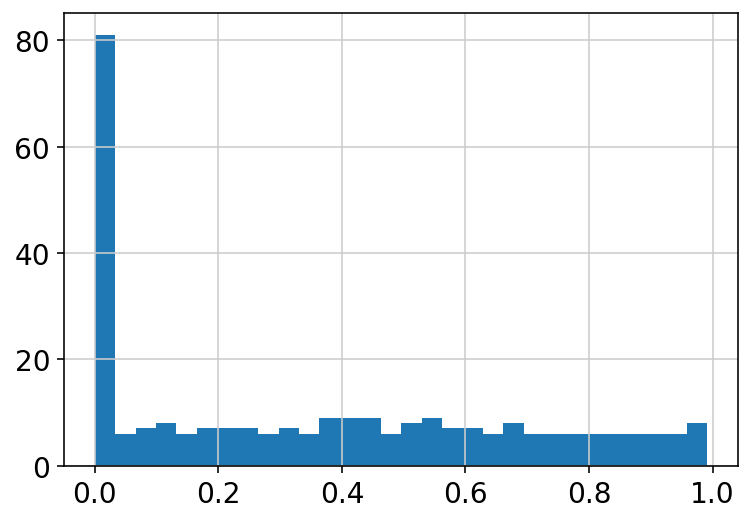

G245C         0.000010
R110L         0.000010
R337L         0.000010
H193L         0.000010
A83V          0.552590
C275F         0.000010
D21D          0.555057
V173M         0.000010
P36P          0.511188
K132R         0.000010
V216M         0.000010
G266V         0.000010
unassigned    0.000010
H193Y         0.000010
Y205C         0.000010
C135F         0.000010
Y234C         0.000010
S127F         0.000010
T312S         0.498915
R213Q         0.000010
Y163C         0.000010
R273L         0.000010
C141Y         0.000010
V272L         0.000010
P153P         0.555288
P250L         0.000010
T118T         0.549805
S241C         0.000010
G154V         0.000010
G245D         0.000010
                ...   
E286K         0.000010
P222P         0.510379
M237I         0.000010
P47S          0.313632
R273C         0.000010
H193R         0.000010
R249M         0.000010
Y236C         0.000010
M246V         0.000010
C277F         0.000010
P278S         0.000010
P295P         0.555057
G266R      

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


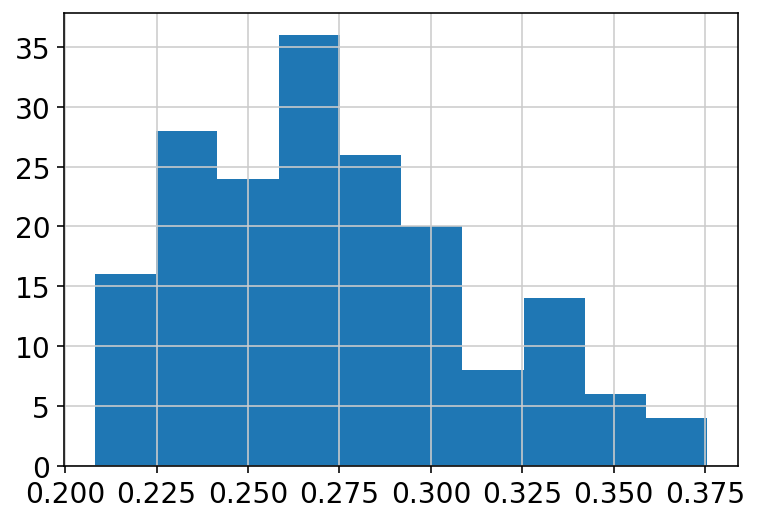

computed ps=== [0.         0.         0.         0.         0.51648352 0.
 0.52747253 0.         0.10989011 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.30769231 0.         0.         0.         0.         0.
 0.62637363 0.         0.74725275 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.16483516 0.64835165 0.21978022 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.73626374 0.41758242 0.51648352 0.
 0.08791209 0.         0.         0.         0.04395604 0.
 0.         0.62637363 0.         0.62637363 0.38461538 0.
 0.         0.         0.02197802 0.         0.         0.35164835
 0.         0.2967033  0.         0.         0.         0.
 0.         0.         0.         0.50549451 0.         0.
 0.         0.         0.34065934 0.         0.38461538 0.
 0.         0.         0.         0.         0.         0.
 0.89010989 0.31868132 0.        

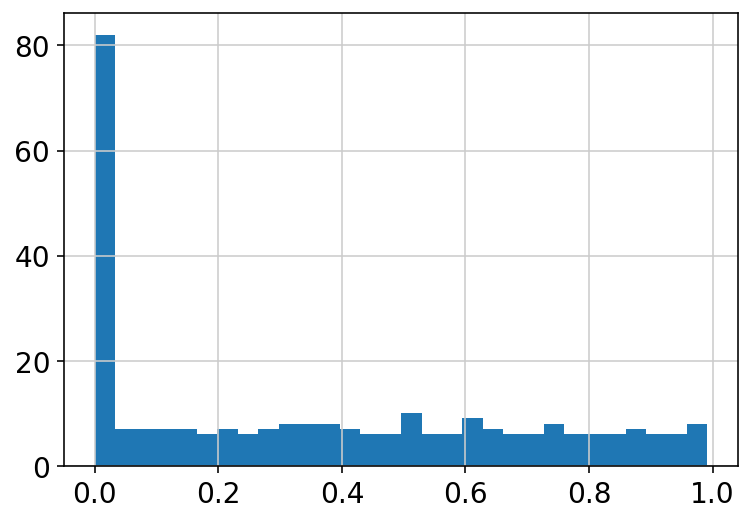

G245C         0.000010
R110L         0.000010
R337L         0.000010
H193L         0.000010
A83V          0.560912
C275F         0.000010
D21D          0.563754
V173M         0.000010
P36P          0.224220
K132R         0.000010
V216M         0.000010
G266V         0.000010
unassigned    0.000010
H193Y         0.000010
Y205C         0.000010
C135F         0.000010
Y234C         0.000010
S127F         0.000010
T312S         0.447150
R213Q         0.000010
Y163C         0.000010
R273L         0.000010
C141Y         0.000010
V272L         0.000010
P153P         0.602512
P250L         0.000010
T118T         0.642319
S241C         0.000010
G154V         0.000010
G245D         0.000010
                ...   
E286K         0.000010
P222P         0.473553
M237I         0.000010
P47S          0.440692
R273C         0.000010
H193R         0.000010
R249M         0.000010
Y236C         0.000010
M246V         0.000010
C277F         0.000010
P278S         0.000010
P295P         0.561043
G266R      

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [129]:
for i in range(1):
    outs[i]={}
    for subs in [1000,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
                
    ]:
        outs[i][subs]={}
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()

        #compute scores and their FDRs
        scores_real2=compare_groups_with_reference(adata_sub,
                                  grouping_variable='guide.compact',
                                 groups=variants,
                                 reference=ref,
                                  controls_for_ci=syn,
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=min(20,subs-1))[0]

        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2.to_csv(out2)

In [117]:
outs[0].loc[syn,:]

,HotellingT2,HotellingT2.ci.0.95.high,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.mean,avg.pearson,avg.pearson.ci.0.95.high,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.mean,group1,group2,HotellingT2.q,dataset,HotellingT2.FDR,avg.pearson.q,avg.pearson.FDR
P222P,23.435942,35.225338,23.925720,29.575529,0.268604,0.298251,0.268600,0.283425,P359P,P222P,0.654673,true data,0.435529,0.543277,0.352028
T170T,17.783919,27.577486,19.524620,23.551053,0.257146,0.272883,0.243033,0.257958,P359P,T170T,0.695119,true data,0.475426,0.608130,0.405060
D21D,19.172868,33.214098,20.466370,26.840234,0.244834,0.280039,0.248808,0.264424,P359P,D21D,0.693234,true data,0.471092,0.646972,0.442881
P153P,25.190010,30.725513,23.200592,26.963053,0.246006,0.278711,0.236120,0.257416,P359P,P153P,0.631175,true data,0.414582,0.648691,0.441865
P36P,24.610440,34.668567,23.561957,29.115262,0.340194,0.348192,0.320141,0.334167,P359P,P36P,0.636034,true data,0.421504,0.144910,0.077032
L344L,30.724415,35.558967,26.125201,30.842084,0.275793,0.301381,0.269502,0.285441,P359P,L344L,0.504767,true data,0.313018,0.519481,0.330033
WT,17.768342,32.890180,22.768815,27.829497,0.284095,0.326165,0.293142,0.309653,P359P,WT,0.695119,true data,0.472869,0.475200,0.295094
E2E,30.283999,32.694785,23.581857,28.138321,0.240713,0.275475,0.233492,0.254484,P359P,E2E,0.514034,true data,0.320171,0.649140,0.442282
R158R,17.814533,28.967264,20.362067,24.664665,0.234604,0.264139,0.228760,0.246449,P359P,R158R,0.695119,true data,0.478011,0.668896,0.460829
P301P,25.275740,30.382981,21.720537,26.051759,0.276903,0.292651,0.261132,0.276892,P359P,P301P,0.629459,true data,0.413073,0.515534,0.326854


In [86]:
method='HotellingT2'
empirical_pvalues(outs[1][method].loc['P359P',syn],outs[3][method])

array([0.72527473, 0.87912088, 0.84615385, 0.63736264, 0.67032967,
       0.37362637, 0.87912088, 0.3956044 , 0.87912088, 0.62637363,
       0.37362637, 0.3956044 , 0.12087912,        nan, 0.67032967])

In [100]:
outs[3][method]

array([10.15676029, 10.15676029, 13.79822429, 13.79822429, 14.63273927,
       14.63273927, 15.31273284, 15.31273284, 15.56107824, 15.56107824,
       15.74980771, 15.74980771, 15.85740052, 15.85740052, 16.19376447,
       16.19376447, 16.48058118, 16.48058118, 17.41429397, 17.41429397,
       17.52549921, 17.52549921, 18.48465746, 18.48465746, 18.6279123 ,
       18.6279123 , 19.01491308, 19.01491308, 19.18199888, 19.18199888,
       19.61015465, 19.61015465, 19.68154756, 19.68154756, 20.1050142 ,
       20.1050142 , 20.75872315, 20.75872315, 21.41937559, 21.41937559,
       22.61371249, 22.61371249, 22.77905205, 22.77905205, 23.06139247,
       23.06139247, 23.21171926, 23.21171926, 23.32910579, 23.32910579,
       23.4435353 , 23.4435353 , 23.4494228 , 23.4494228 , 23.45938895,
       23.45938895, 23.89608259, 23.89608259, 23.95295843, 23.95295843,
       24.77720803, 24.77720803, 24.79211022, 24.79211022, 24.99667405,
       24.99667405, 25.24991745, 25.24991745, 25.49371053, 25.49

In [87]:
outs[3][method].sort()
print(outs[3][method])

[10.15676029 10.15676029 13.79822429 13.79822429 14.63273927 14.63273927
 15.31273284 15.31273284 15.56107824 15.56107824 15.74980771 15.74980771
 15.85740052 15.85740052 16.19376447 16.19376447 16.48058118 16.48058118
 17.41429397 17.41429397 17.52549921 17.52549921 18.48465746 18.48465746
 18.6279123  18.6279123  19.01491308 19.01491308 19.18199888 19.18199888
 19.61015465 19.61015465 19.68154756 19.68154756 20.1050142  20.1050142
 20.75872315 20.75872315 21.41937559 21.41937559 22.61371249 22.61371249
 22.77905205 22.77905205 23.06139247 23.06139247 23.21171926 23.21171926
 23.32910579 23.32910579 23.4435353  23.4435353  23.4494228  23.4494228
 23.45938895 23.45938895 23.89608259 23.89608259 23.95295843 23.95295843
 24.77720803 24.77720803 24.79211022 24.79211022 24.99667405 24.99667405
 25.24991745 25.24991745 25.49371053 25.49371053 25.84310417 25.84310417
 25.8533088  25.8533088  26.0373113  26.0373113  26.16273706 26.16273706
 26.33204817 26.33204817 26.4075709  26.4075709  26.9

In [96]:
vs=list(outs[0][method].index)
print(ps)
ps=pd.DataFrame({'p':list(ps)},index=vs)

           0
0   0.000000
1   0.000000
2   0.000000
3   0.000000
4   0.428571
5   0.000000
6   0.846154
7   0.000000
8   0.670330
9   0.000000
10  0.000000
11  0.000000
12  0.000000
13  0.000000
14  0.000000
15  0.000000
16  0.000000
17  0.000000
18  0.428571
19  0.000000
20  0.000000
21  0.000000
22  0.000000
23  0.000000
24  0.637363
25  0.000000
26  0.670330
27  0.000000
28  0.000000
29  0.000000
..       ...
70  0.000000
71  0.725275
72  0.000000
73  0.230769
74  0.000000
75  0.000000
76  0.000000
77  0.000000
78  0.000000
79  0.000000
80  0.000000
81  0.395604
82  0.000000
83  0.000000
84  0.000000
85  0.000000
86  0.373626
87  0.000000
88  0.901099
89  0.000000
90  0.000000
91  0.000000
92  0.000000
93  0.000000
94  0.000000
95  0.000000
96  0.054945
97  0.120879
98  0.000000
99  0.000000

[100 rows x 1 columns]


In [97]:
ps.loc[syn]

,p
P222P,0
T170T,0
D21D,0
P153P,0
P36P,0
L344L,0
WT,0
E2E,0
R158R,0
P301P,0


In [98]:
outs[1][method].loc['P359P',syn].sort_values()

WT       17.7683
T170T    17.7839
R158R    17.8145
D21D     19.1729
P222P    23.4359
P36P     24.6104
T118T     24.696
P153P      25.19
P301P    25.2757
P295P    30.0444
E2E       30.284
P47P     30.6788
L344L    30.7244
V216V    39.0331
P359P        NaN
Name: P359P, dtype: object

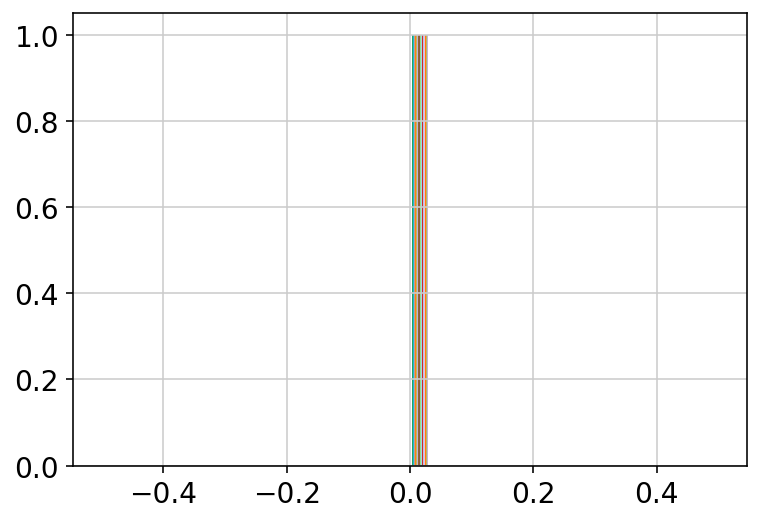

AttributeError: 'DataFrame' object has no attribute 'sort'

In [99]:
qvalue(ps)

In [23]:
scores.head()

,HotellingT2,HotellingT2.ci.0.95.high,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.mean,avg.pearson,avg.pearson.ci.0.95.high,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.mean,group1,group2,HotellingT2.q,dataset,HotellingT2.FDR,avg.pearson.q,avg.pearson.FDR
G245V,388.953156,382.802009,328.156711,355.479360,1.520700,1.492905,1.464304,1.478604,P359P,G245V,0.20381,true data,0.003378,0.207619,0.003378
R273L,205.372260,204.404584,173.057209,188.730897,1.054982,1.041595,1.013759,1.027677,P359P,R273L,0.20381,true data,0.003378,0.207619,0.003378
R249M,397.286499,398.250888,344.527857,371.389372,1.516609,1.500952,1.466642,1.483797,P359P,R249M,0.20381,true data,0.003378,0.207619,0.003378
I195T,346.104612,344.680510,294.396631,319.538570,1.548720,1.535273,1.492512,1.513893,P359P,I195T,0.20381,true data,0.003378,0.207619,0.003378
R213Q,105.501075,121.585842,98.722123,110.153983,0.870858,0.904507,0.870946,0.887726,P359P,R213Q,0.20381,true data,0.003378,0.207619,0.003378


In [19]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [22]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'
for i in range(3):
    print(i)
    outs[i]={}
    for subs in [1000,200,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)
        print(scores_real2.head())

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                print(method,fdr,'impactful',len(impactful))
                
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                '''
                #now, go through each cluster of variants and compute (vs original ctrls)
                for cl in ['#99CCFF', 'navy']:
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    res[method]=pd.concat([res[method],res_here])
                '''
                
    

0
       HotellingT2  HotellingT2.ci.0.95.high  HotellingT2.ci.0.95.low  \
G245V   388.953156                382.802009               328.156711   
R273L   205.372260                204.404584               173.057209   
R249M   397.286499                398.250888               344.527857   
I195T   346.104612                344.680510               294.396631   
R213Q   105.501075                121.585842                98.722123   

       HotellingT2.ci.0.95.mean  avg.pearson  avg.pearson.ci.0.95.high  \
G245V                355.479360     1.520700                  1.492905   
R273L                188.730897     1.054982                  1.041595   
R249M                371.389372     1.516609                  1.500952   
I195T                319.538570     1.548720                  1.535273   
R213Q                110.153983     0.870858                  0.904507   

       avg.pearson.ci.0.95.low  avg.pearson.ci.0.95.mean group1 group2  \
G245V                 1.464304          

ZeroDivisionError: float division by zero

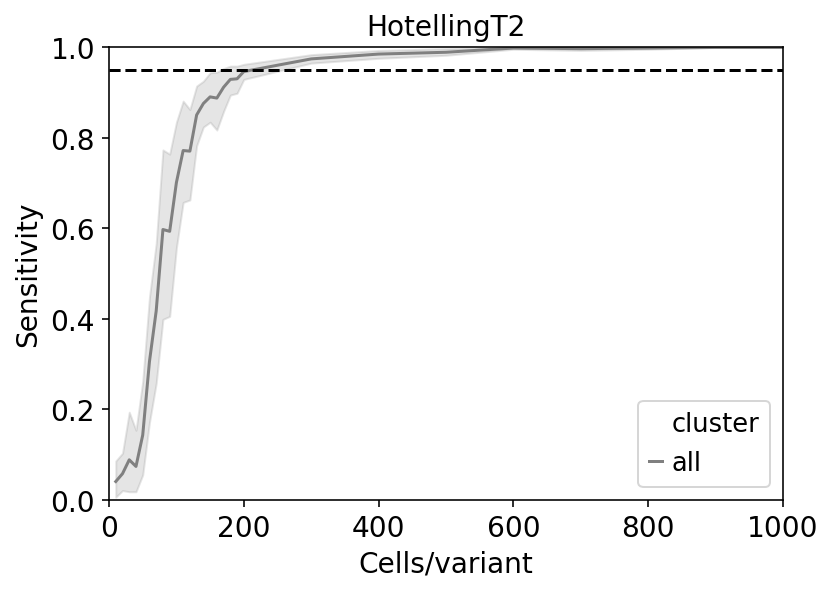

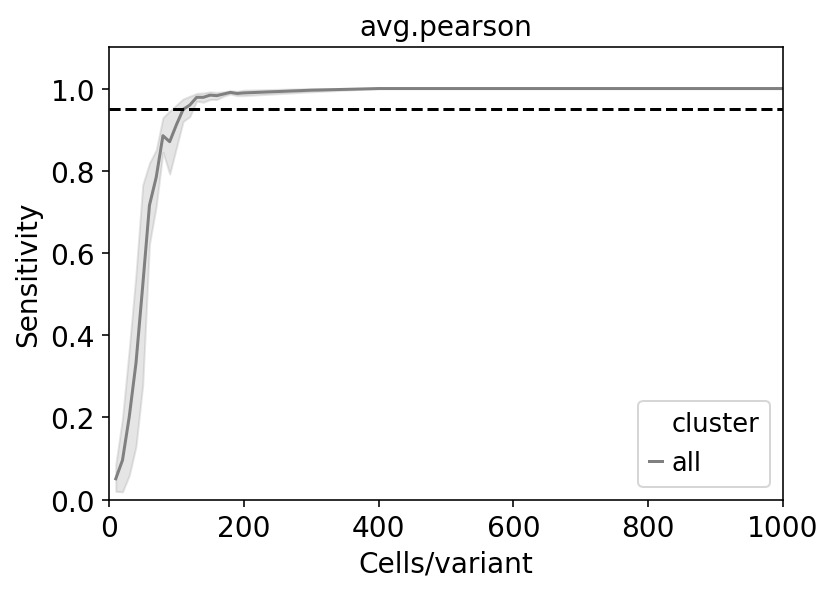

In [119]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

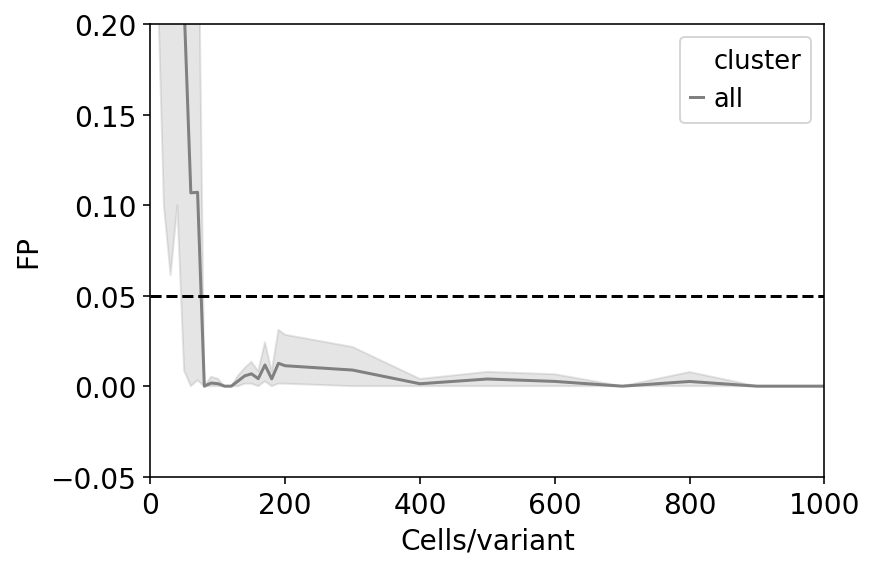

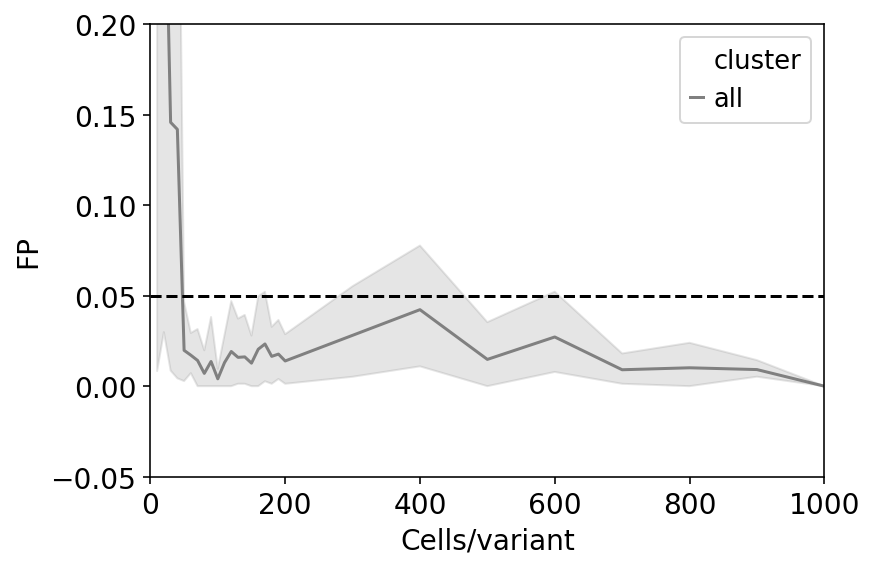

In [121]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [6]:
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

['P359P', 'T170T', 'D21D', 'A83V', 'P153P', 'E2E', 'P47P', 'P295P', 'R158R', 'T118T', 'Q5R', 'G360V', 'V31I', 'P36P', 'P58R', 'P222P', 'T312S', 'P301P', 'L344L', 'P47S', 'WT', 'E339K', 'Y107H', 'S366A', 'V216V', 'R337C', 'R337L', 'unassigned', 'C277F', 'R280K', 'R213Q', 'P152L', 'S241C', 'R273H', 'R273L', 'R273C', 'K132R', 'R158H', 'M246V', 'M237I', 'V272L', 'C242F', 'E271K', 'Y205C', 'G154V', 'Y234C', 'Y220C', 'G266E', 'Y236C', 'R280T', 'R158L', 'R248W', 'C238F', 'Y163C', 'G266V', 'A159V', 'E285K', 'G105C', 'G245C', 'H179R', 'K132N', 'S241F', 'R248L', 'V272M', 'H193R', 'G245S', 'P250L', 'C141Y', 'P278L', 'A159P', 'G244C', 'E286K', 'S127F', 'C238Y', 'V216M', 'V173L', 'V157F', 'C176Y', 'C176F', 'H214R', 'H193Y', 'R110L', 'C135Y', 'R249S', 'R282W', 'L194R', 'G266R', 'R249M', 'G245V', 'C275Y', 'H179Y', 'P151S', 'R175H', 'C135F', 'I195T', 'P278S', 'V173M', 'G245D', 'H193L', 'C275F']


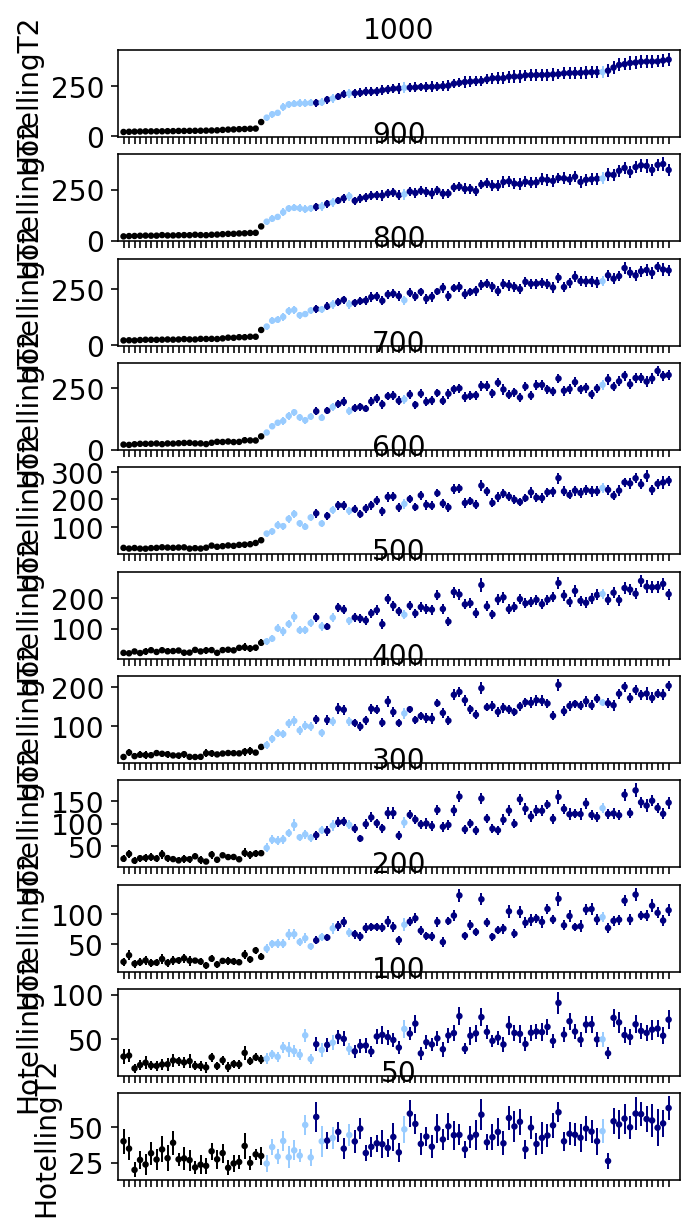

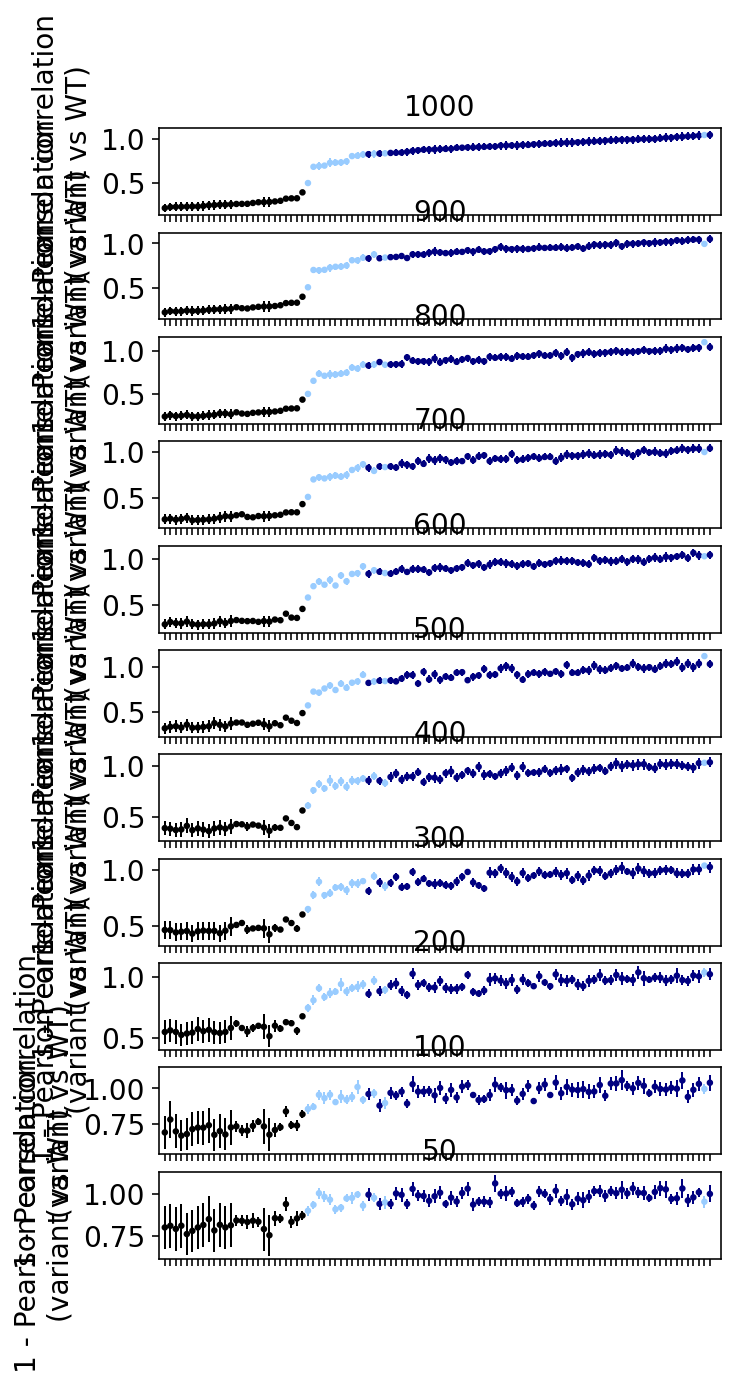

In [7]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    print('new')
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)


subs_list=[1000,900,800,700,600,500,400,300,200,100,50]


methods=['HotellingT2','avg.pearson']
for method in methods:
    SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
    scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
    scores=pd.read_csv(scorefile,header=0,index_col=0)
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=[method+'.ci.0.95.mean'],ascending=True)

    fig,plots=plt.subplots(len(subs_list),1)
    fig.set_size_inches(5,10)
    c=0
    for subs in subs_list:

        SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
        scorefile=SCORE_DIR+'/scores.iter0.cells'+str(subs)+'.cells.csv'
        scores=pd.read_csv(scorefile,header=0,index_col=0)        

        w=10
        h=6
        
        plot_with_errorbars(list(anno.index),
                            scores.loc[anno.index,method+'.ci.0.95.mean'],
                           scores.loc[anno.index,method+'.ci.0.95.low'],
                           scores.loc[anno.index,method+'.ci.0.95.high'],
                            plots=plots[c],
                            flip_axes=False,
                            color_lines=list(anno.loc[anno.index,'cluster_color']),

                            s=5,
                           c=list(anno.loc[anno.index,'cluster_color']))

        if method=='avg.pearson':
            plots[c].set_ylabel('1 - Pearson correlation\n(variant vs WT)')
            #plots[c].set_ylim(0,1.5)
            #plots[c].set_yticks([0,0.5,1.0,1.5])
        if method=='HotellingT2':
            plots[c].set_ylabel('HotellingT2')
            #plots.set_ylim(0,1.5)
            #plots.set_yticks([0,0.5,1.0,1.5])
        plots[c].set_xticklabels([])
        plots[c].set_xlim(-1,101)

        #figure out FDR line
        #thresh=get_threshold_at_FDR(scores,method,statname='.q',FDR=0.05)
        #plots[c].axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
        plots[c].set_title(str(subs))
        c+=1
    plt.show()

Analyze scores as a function of number of PCs
===

In [123]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)

            out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
            cell_ids=list(pd.read_csv(out).iloc[:,0])

            #get subsample
            adata_sub=adata[cell_ids,:].copy()

            #compute scores and their FDRs
            scores_real2=compare_groups_with_reference(adata_sub,
                                      grouping_variable='guide.compact',
                                     groups=variants,
                                     reference=ref,
                                      controls_for_ci=syn,
                                      ci_size=0.95,
                                     methods=['HotellingT2','avg.pearson'],
                                     num_pcs_hotelling=min(pc,subs-1))[0]

            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2.to_csv(out2)

cells 1000
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 1000
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 1000


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 50
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 50
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 50


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 1000
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 1000
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 1000
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


cells 200
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 50


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 50


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
cells 50
Found 15/15 controls for CI computation
100 %controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)
controls 14
score mat shaoe (15, 100)
emp scores shape (196,)
shape sq (14, 14)
min fdr 0.0033783783783783786 (296, 3)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
K

In [134]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)

In [135]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)
            
            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2=pd.read_csv(out2,index_col=0)

            for fdr in [fdr_total]:

                for method in methods:

                    #all variants
                    #============
                    #get impactful variants
                    impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                    ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                    print(method,fdr,'impactful',len(impactful))

                    pre,rec=get_precision_recall(scores_real2,
                                                 method+thestat,
                                                 impactful,fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'pc':pc,
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                    res[method]=pd.concat([res[method],res_here])
            
            

cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 1000
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 200


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75
cells 50
HotellingT2 0.05 impactful 75
avg.pearson 0.05 impactful 75


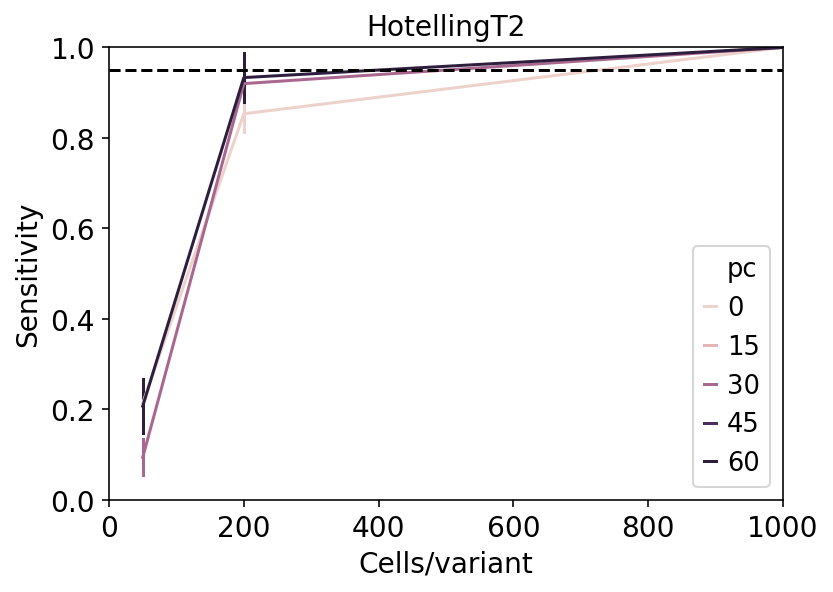

In [139]:
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='pc', 
    #cmap='tab20',
    err_style="bars",
    
    ci=68,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()



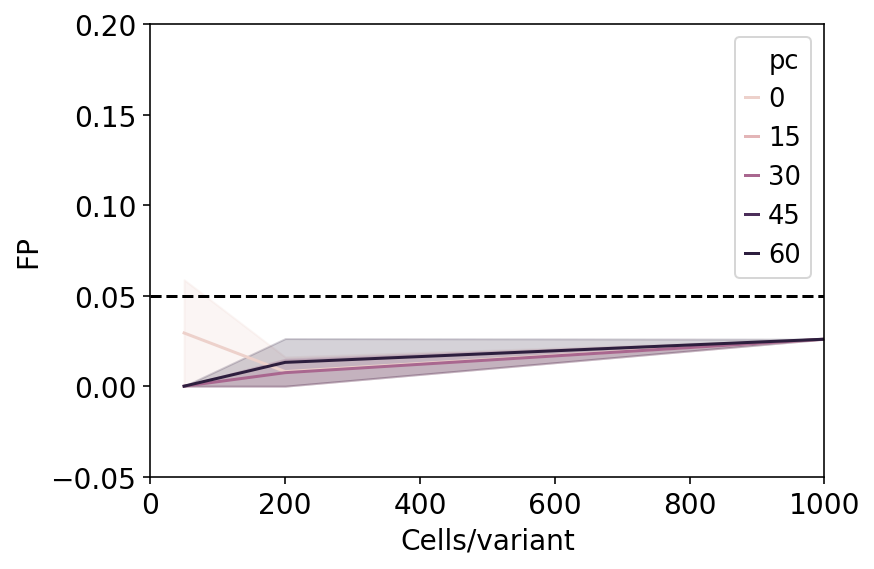

In [140]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='pc', 
    #cmap='tab20',
    #err_style="bars",
    ci=68,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()

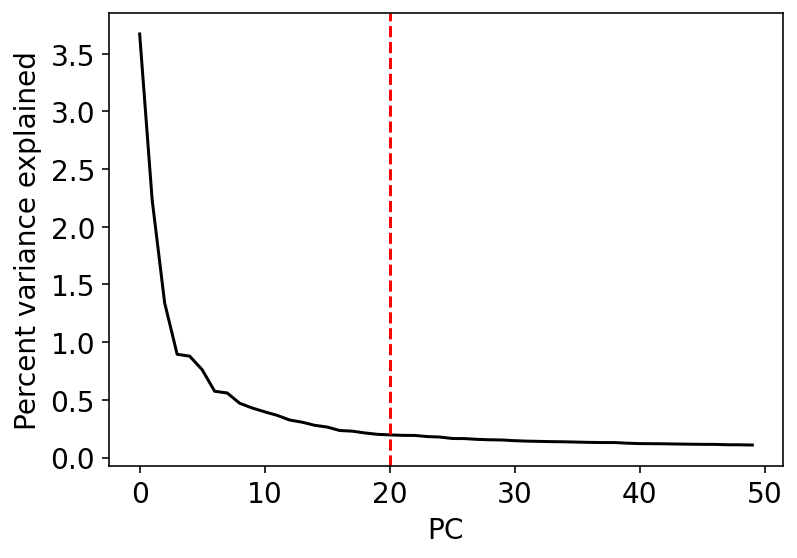

In [153]:
plt.plot(adata.uns['pca']['variance']/adata.n_vars*100,
        color='black')
plt.axvline(x=20,color='red',linestyle='--')
plt.xlabel('PC')
plt.ylabel('Percent variance explained')
plt.grid(False)

In [146]:
adata.uns['pca']['variance']/adata.n_vars*100

array([3.67078657, 2.23324391, 1.33960606, 0.89447598, 0.87854664,
       0.76078505, 0.5742059 , 0.55958482, 0.47039573, 0.42933507,
       0.39625307, 0.36549617, 0.32505931, 0.30606214, 0.27925024,
       0.26409954, 0.23419599, 0.22869494, 0.21313112, 0.20119481,
       0.1963611 , 0.19220329, 0.19149587, 0.18175944, 0.17753119,
       0.16493366, 0.16406633, 0.15741533, 0.15389387, 0.15192437,
       0.14596314, 0.14210972, 0.13993897, 0.13764306, 0.13630906,
       0.13374073, 0.1313885 , 0.12991617, 0.12978673, 0.12421726,
       0.12071088, 0.11989203, 0.11901259, 0.11700884, 0.11562625,
       0.114188  , 0.11403188, 0.11068488, 0.11039543, 0.10818996])

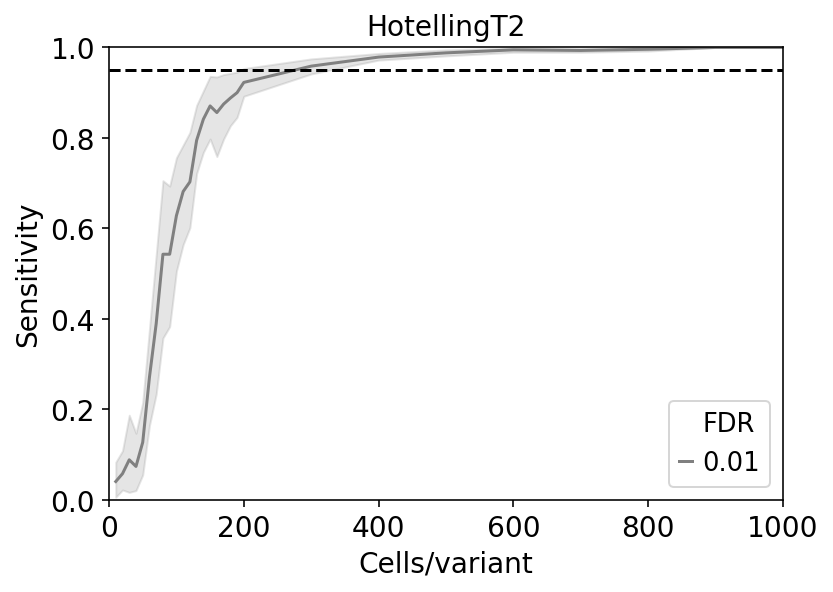

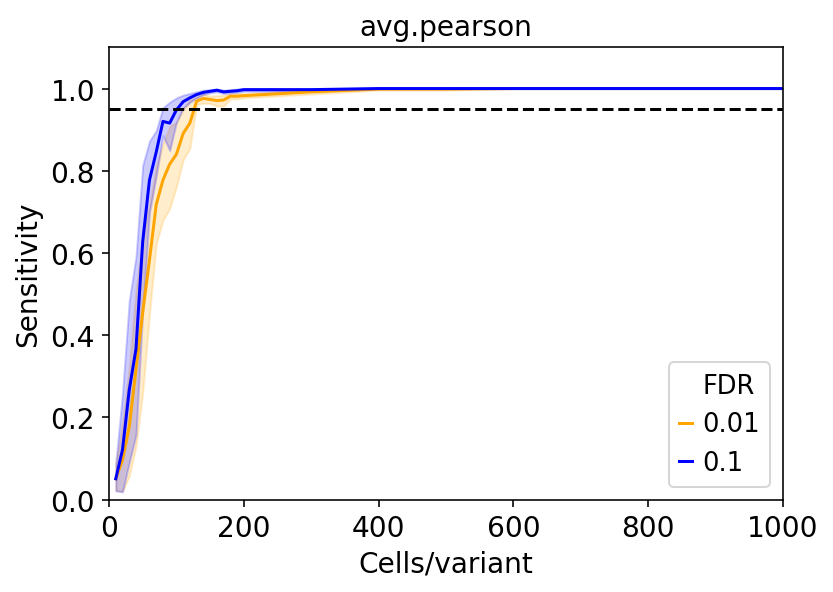

In [80]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==0.01,:], 
    x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method], x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()


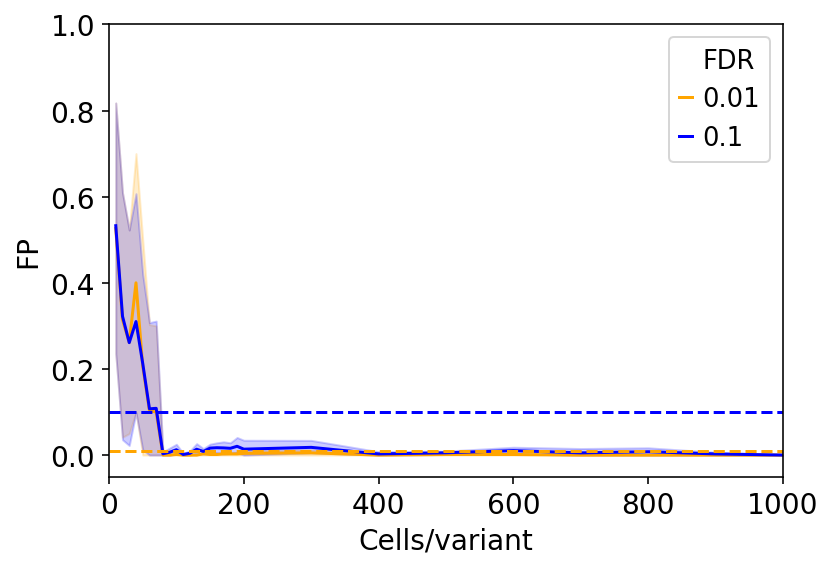

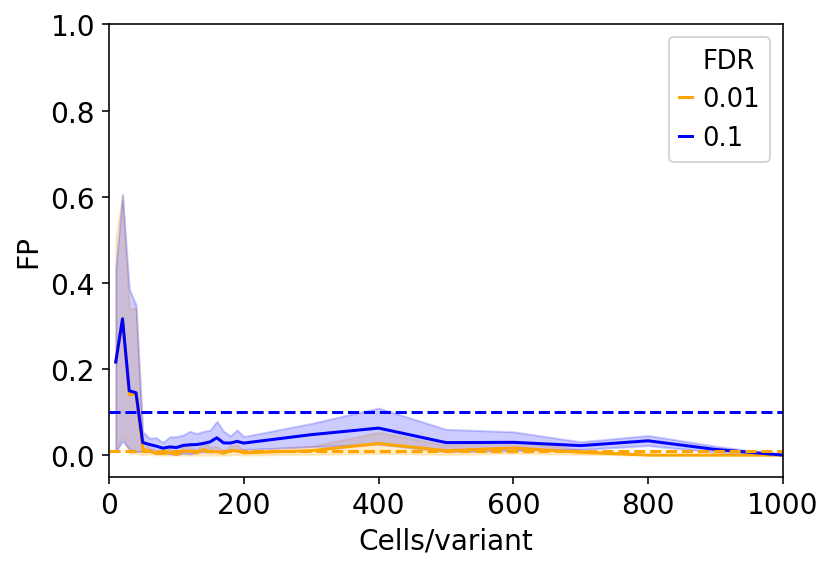

In [81]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [130]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]

thresh 68.53689253064707


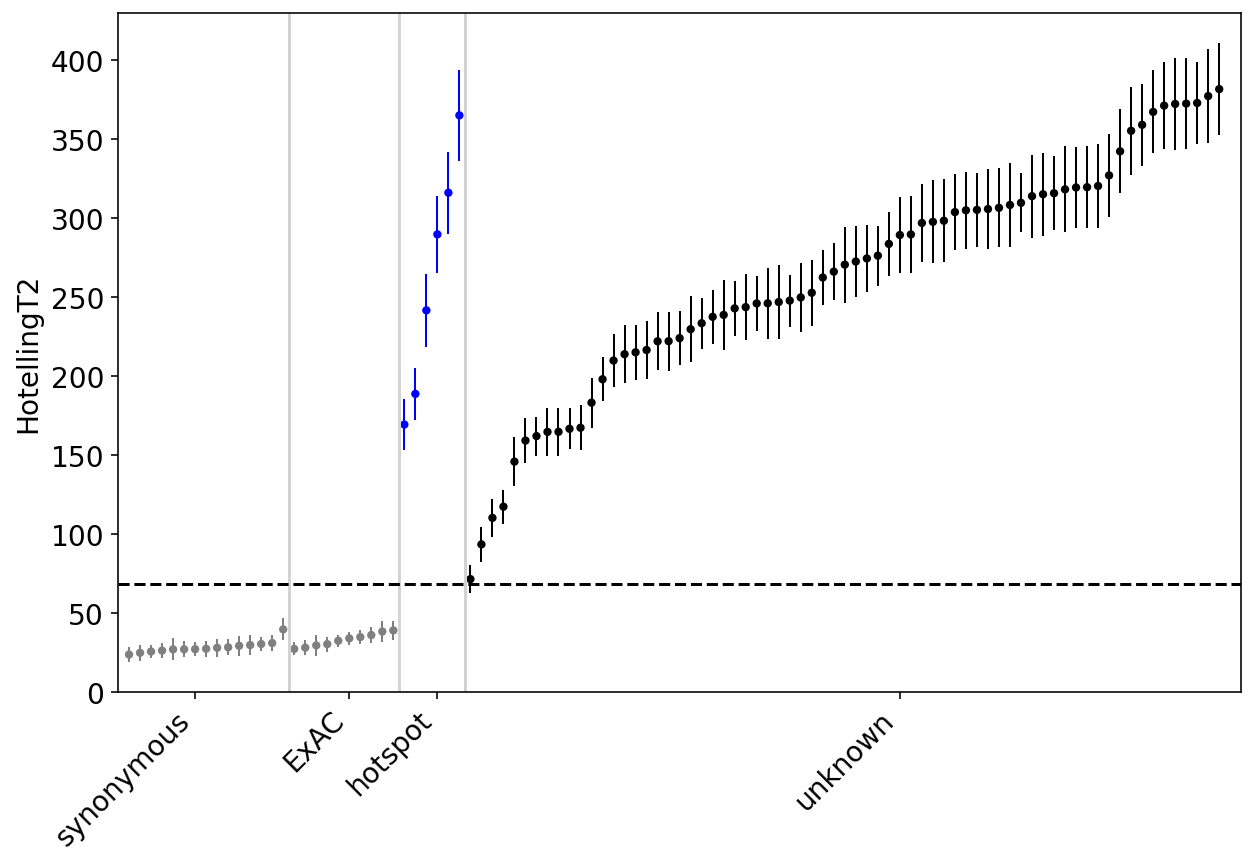

thresh 0.3563875171601315


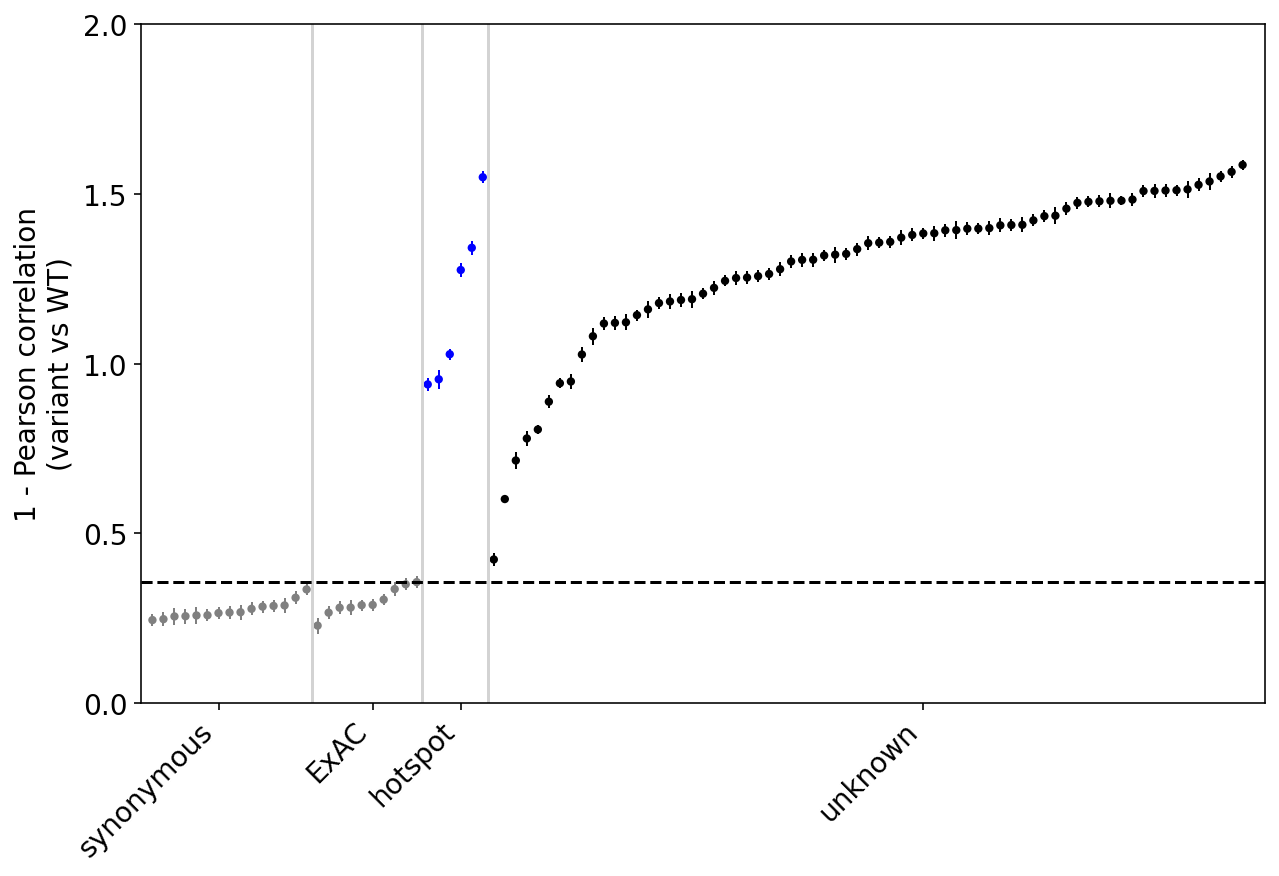

In [144]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.sort_values(by=['control_status2',method+'.ci.0.95.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.ci.0.95.mean'],
                        #scores.loc[anno.index,method],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[:,'text_color']),

                        s=10,
                       c=list(anno.loc[:,'text_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=30.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,1.5)
        plots.set_yticks([0,0.5,1.0,1.5,2.0])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,28,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,method,statname='.FDR',FDR=0.05)
    print('thresh',thresh)
    plt.axhline(y=thresh,color='black',linestyle='--')
    plt.show()

In [137]:
scores.loc[syn,:].sort_values(by='HotellingT2.ci.0.95.mean')

,HotellingT2,HotellingT2.ci.0.95.high,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.mean,avg.pearson,avg.pearson.ci.0.95.high,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.mean,group1,group2,HotellingT2.q,dataset,HotellingT2.FDR,avg.pearson.q,avg.pearson.FDR
T170T,17.783919,27.577486,19.524620,23.551053,0.257146,0.272883,0.243033,0.257958,P359P,T170T,0.606535,true data,0.475426,0.602512,0.405060
R158R,17.814533,28.967264,20.362067,24.664665,0.234604,0.264139,0.228760,0.246449,P359P,R158R,0.600567,true data,0.478011,0.641057,0.460829
P359P,0.000000,29.063959,21.866404,25.465182,0.000000,0.281826,0.250235,0.266030,P359P,P359P,0.585009,true data,0.500000,0.560912,0.500000
P301P,25.275740,30.382981,21.720537,26.051759,0.276903,0.292651,0.261132,0.276892,P359P,P301P,0.568072,true data,0.413073,0.511222,0.326854
D21D,19.172868,33.214098,20.466370,26.840234,0.244834,0.280039,0.248808,0.264424,P359P,D21D,0.555057,true data,0.471092,0.563754,0.442881
P295P,30.044431,31.405582,22.353073,26.879328,0.268208,0.285570,0.248165,0.266868,P359P,P295P,0.555057,true data,0.317600,0.561043,0.349484
P153P,25.190010,30.725513,23.200592,26.963053,0.246006,0.278711,0.236120,0.257416,P359P,P153P,0.555288,true data,0.414582,0.602512,0.441865
T118T,24.696012,31.606286,22.829284,27.217785,0.239301,0.257969,0.229636,0.243802,P359P,T118T,0.549805,true data,0.424171,0.642319,0.450117
WT,17.768342,32.890180,22.768815,27.829497,0.284095,0.326165,0.293142,0.309653,P359P,WT,0.522198,true data,0.472869,0.302697,0.295094
E2E,30.283999,32.694785,23.581857,28.138321,0.240713,0.275475,0.233492,0.254484,P359P,E2E,0.522198,true data,0.320171,0.609149,0.442282


In [52]:
scores.loc[syn,].sort_values(by='HotellingT2.q')

,HotellingT2,HotellingT2.ci.0.95.high,HotellingT2.ci.0.95.low,HotellingT2.ci.0.95.mean,avg.pearson,avg.pearson.ci.0.95.high,avg.pearson.ci.0.95.low,avg.pearson.ci.0.95.mean,group1,group2,HotellingT2.q,dataset,HotellingT2.FDR,avg.pearson.q,avg.pearson.FDR
P222P,23.435942,35.225338,23.925720,29.575529,0.268604,0.298251,0.268600,0.283425,P359P,P222P,0.000010,true data,0.435529,0.000010,0.352028
D21D,19.172868,33.214098,20.466370,26.840234,0.244834,0.280039,0.248808,0.264424,P359P,D21D,0.000010,true data,0.471092,0.000010,0.442881
P153P,25.190010,30.725513,23.200592,26.963053,0.246006,0.278711,0.236120,0.257416,P359P,P153P,0.000010,true data,0.414582,0.000010,0.441865
P36P,24.610440,34.668567,23.561957,29.115262,0.340194,0.348192,0.320141,0.334167,P359P,P36P,0.000010,true data,0.421504,0.000010,0.077032
WT,17.768342,32.890180,22.768815,27.829497,0.284095,0.326165,0.293142,0.309653,P359P,WT,0.000010,true data,0.472869,0.000010,0.295094
E2E,30.283999,32.694785,23.581857,28.138321,0.240713,0.275475,0.233492,0.254484,P359P,E2E,0.000010,true data,0.320171,0.000010,0.442282
P47P,30.678844,34.109830,26.340739,30.225285,0.262208,0.273925,0.236398,0.255161,P359P,P47P,0.000010,true data,0.310417,0.000010,0.376478
V216V,39.033052,45.864528,33.119135,39.491832,0.285816,0.307356,0.266471,0.286913,P359P,V216V,0.000010,true data,0.134179,0.000010,0.277432
T118T,24.696012,31.606286,22.829284,27.217785,0.239301,0.257969,0.229636,0.243802,P359P,T118T,0.000010,true data,0.424171,0.000010,0.450117
R158R,17.814533,28.967264,20.362067,24.664665,0.234604,0.264139,0.228760,0.246449,P359P,R158R,0.035471,true data,0.478011,0.034775,0.460829
